# Imports

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import json
import os
from pprint import pprint
import sys

import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib import colors, gridspec
import numpy as np
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression, HuberRegressor
project_root = '..'
sys.path.append(project_root)

from sleeprnn.common import constants, pkeys, viz
from sleeprnn.common.optimal_thresholds import OPTIMAL_THR_FOR_CKPT_DICT
from sleeprnn.data import utils, stamp_correction
from sleeprnn.detection.feeder_dataset import FeederDataset
from sleeprnn.detection.postprocessor import PostProcessor
from sleeprnn.detection import metrics
from sleeprnn.helpers import reader, plotter, printer, misc, performer

RESULTS_PATH = os.path.join(project_root, 'results')
COMPARISON_PATH = os.path.join(project_root, 'resources', 'comparison_data')

%matplotlib inline
viz.notebook_full_width()

Intel(R) Data Analytics Acceleration Library (Intel(R) DAAL) solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


# Load data

In [4]:
filter_dates = [20200724, None]
printer.print_available_ckpt(OPTIMAL_THR_FOR_CKPT_DICT, filter_dates)

Available ckpt:
    20200724_reproduce_red_n2_train_mass_ss/v19_rep2
    20200724_reproduce_red_n2_train_mass_ss/v19_rep4
    20200724_reproduce_red_n2_train_mass_ss/v19_rep1
    20200724_reproduce_red_n2_train_mass_ss/v19_rep3
    20200724_reproduce_red_n2_train_mass_ss/v11_rep2
    20200724_reproduce_red_n2_train_mass_ss/v11_rep3
    20200724_reproduce_red_n2_train_mass_ss/v11_rep4
    20200724_reproduce_red_n2_train_mass_ss/v11_rep1
    20200724_reproduce_red_n2_train_mass_kc/v19_rep3
    20200724_reproduce_red_n2_train_mass_kc/v19_rep2
    20200724_reproduce_red_n2_train_mass_kc/v19_rep1
    20200724_reproduce_red_n2_train_mass_kc/v19_rep4
    20200724_reproduce_red_n2_train_mass_kc/v11_rep3
    20200724_reproduce_red_n2_train_mass_kc/v11_rep2
    20200724_reproduce_red_n2_train_mass_kc/v11_rep4
    20200724_reproduce_red_n2_train_mass_kc/v11_rep1
    20200914_fft_based_norm_n2_train_mass_ss/v11_rep2
    20200914_fft_based_norm_n2_train_mass_ss/v11_rep1
    20200914_fft_based_norm_

In [5]:
dataset_name = constants.MASS_SS_NAME
fs = 200
which_expert = 1
task_mode = constants.N2_RECORD
seed_id_list = [i for i in range(4)]
set_list = [constants.VAL_SUBSET, constants.TRAIN_SUBSET]

# Specify what to load
comparison_runs_list = [
    ('20200724_reproduce_red_n2_train_mass_ss/v19_rep1', 'RED-CWT'),
    ('20201006_noisy_cwt_n2_train_mass_ss/v19_noisy_intens0.05', 'Noise0.05'),
    ('20201006_noisy_cwt_n2_train_mass_ss/v19_noisy_intens0.10', 'Noise0.10'),
]
comparison_runs_list = [
    (t_folder, t_label) for (t_folder, t_label) in comparison_runs_list if dataset_name in t_folder
]
ckpt_folder_list = [t_folder for (t_folder, t_label) in comparison_runs_list]
ckpt_folder_dict = {t_label: t_folder for (t_folder, t_label) in comparison_runs_list}
ckpt_label_dict = {t_folder: t_label for (t_folder, t_label) in comparison_runs_list}

# Load data
n_cases = len(comparison_runs_list)
dataset = reader.load_dataset(dataset_name, params={pkeys.FS: fs})
ids_dict = {
    constants.ALL_TRAIN_SUBSET: dataset.train_ids,
    constants.TEST_SUBSET: dataset.test_ids}
ids_dict.update(misc.get_splits_dict(dataset, seed_id_list))
predictions_dict = {}
for ckpt_folder in ckpt_folder_list:
    predictions_dict[ckpt_folder] = reader.read_prediction_with_seeds(
        ckpt_folder, dataset_name, task_mode, seed_id_list, set_list=set_list, parent_dataset=dataset)
# useful for viz
iou_hist_bins = np.linspace(0, 1, 21)
iou_curve_axis = misc.custom_linspace(0.05, 0.95, 0.05)
result_id = '%s-%s-E%d-%s' % (
    dataset_name.split('_')[0].upper(), 
    dataset_name.split('_')[1].upper(), 
    which_expert,
    task_mode.upper())
expert_data_dict = reader.load_ss_expert_performance()
exp_keys = list(expert_data_dict.keys())
print('\nAvailable data:')
pprint(exp_keys)

Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_ss with 15 patients.
Loading from checkpoint... Loaded
Global STD: 16.482042
Loading predictions
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20200724_reproduce_red_n2_train_mass_ss/v19_rep1/seed0
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20200724_reproduce_red_n2_train_mass_ss/v19_rep1/seed1
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20200724_reproduce_red_n2_train_mass_ss/v19_rep1/seed2
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20200724_reproduce_red_n2_train_mass_ss/v19_rep1/seed3
Loading predictions
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20201006_noisy_cwt_n2_train_mass_ss/v19_noisy_intens0.05/seed0
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20201006_noisy_cwt_n2_train_ma

# Output values distribution

In [ ]:
bins = np.linspace(0, 1, num=11)
for ckpt_folder in ckpt_folder_list:
    fig, ax = plt.subplots(len(dataset.train_ids), 5, figsize=(8, 8), dpi=120, sharex=True)
    print(ckpt_folder)
    ax[0, 0].set_title('True Positives (N2)', fontsize=9)
    ax[0, 1].set_title('False Positives (N2)', fontsize=9)
    ax[0, 2].set_title('False Negatives (N2)', fontsize=9)
    ax[0, 3].set_title('TP+FP (N2)', fontsize=9)
    ax[0, 4].set_title('TP+FN (N2)', fontsize=9)
    subject_global_idx = 0
    shown_subjects = []
    for k in seed_id_list:
        this_thr = OPTIMAL_THR_FOR_CKPT_DICT[ckpt_folder][k]
        t_preds = predictions_dict[ckpt_folder][k][constants.VAL_SUBSET]
        t_preds.set_probability_threshold(this_thr)
        t_dets = t_preds.get_stamps()
        t_probas = t_preds.get_probabilities()
        this_ids = ids_dict[k][constants.VAL_SUBSET]
        data_inference = FeederDataset(dataset, this_ids, task_mode, which_expert=which_expert)
        this_events_list = data_inference.get_stamps()
        this_pages_n2_list = data_inference.get_pages(pages_subset=constants.N2_RECORD)
        for i, single_id in enumerate(this_ids):
            if single_id in shown_subjects:
                continue
            shown_subjects.append(single_id)
            proba = t_probas[i]
            events = (this_events_list[i] / 8).astype(np.int32)
            dets = (t_dets[i] / 8).astype(np.int32)
            iou_matching, idx_matching = metrics.matching(events, dets)
            # Find median probability inside detections
            dets_median = [np.median(proba[t0:tf]) for (t0, tf) in dets]
            dets_median = np.array(dets_median)
            # Find median probability inside events
            events_median = [np.median(proba[t0:tf]) for (t0, tf) in events]
            events_median = np.array(events_median)
            # TP indices
            tp_idx = idx_matching[idx_matching != -1]
            tp_median = dets_median[tp_idx]  # We use median on detections because of differences in Overlap
            # FP indices
            fp_idx = [i for i in range(dets.shape[0]) if i not in idx_matching]
            fp_median = dets_median[fp_idx]
            # FN indices
            fn_idx = np.where(idx_matching == -1)[0]
            fn_median = events_median[fn_idx]
            # Now plot statistics
            ax[subject_global_idx, 0].set_ylabel('S%02d' % single_id, fontsize=9)
            
            ax[subject_global_idx, 0].hist(tp_median, bins=bins)
            n1, _, _ = ax[subject_global_idx, 1].hist(fp_median, bins=bins)
            n2, _, _ = ax[subject_global_idx, 2].hist(fn_median, bins=bins)
            
            n = max(n1.max(), n2.max())
            ax[subject_global_idx, 1].set_ylim([0, n])
            ax[subject_global_idx, 2].set_ylim([0, n])
            
            tp_fp = np.concatenate([tp_median, fp_median])
            ax[subject_global_idx, 3].hist(tp_fp, bins=bins)
            tp_fn = np.concatenate([tp_median, fn_median])
            ax[subject_global_idx, 4].hist(tp_fn, bins=bins)
            
            ax[subject_global_idx, 0].axvline(x=this_thr, color='k', linewidth=1)
            ax[subject_global_idx, 1].axvline(x=this_thr, color='k', linewidth=1)
            ax[subject_global_idx, 2].axvline(x=this_thr, color='k', linewidth=1)
            ax[subject_global_idx, 3].axvline(x=this_thr, color='k', linewidth=1)
            ax[subject_global_idx, 4].axvline(x=this_thr, color='k', linewidth=1)
            
            subject_global_idx += 1
    for s_ax in ax.flatten():
        s_ax.set_xlim([0, 1])
        s_ax.tick_params(labelsize=7)
    plt.tight_layout()
    plt.show()

In [9]:
save_figs = True

# General xVal Performance

In [6]:
# Performance
data_dict = {}
for ckpt_folder in ckpt_folder_list:
    print(ckpt_label_dict[ckpt_folder])
    t_data_dict = performer.performance_vs_iou_with_seeds(
        dataset,
        predictions_dict[ckpt_folder],
        OPTIMAL_THR_FOR_CKPT_DICT[ckpt_folder],
        iou_curve_axis,
        iou_hist_bins,
        task_mode,
        which_expert,
        set_name=constants.VAL_SUBSET
    )
    
    # Mean performance
    print('Val AF1: %1.2f +- %1.2f' % (
        100 * t_data_dict[constants.MEAN_AF1].mean(), 100 * t_data_dict[constants.MEAN_AF1].std()
    ))
    print('Val Mean IoU at TP: %1.2f +- %1.2f' % (
        100 * t_data_dict[constants.MEAN_IOU].mean(), 100 * t_data_dict[constants.MEAN_IOU].std()
    ))
    
    data_dict[ckpt_folder] = t_data_dict
    print("")

RED-CWT
Val AF1: 67.73 +- 1.96
Val Mean IoU at TP: 84.40 +- 1.58

Noise0.05
Val AF1: 67.99 +- 2.60
Val Mean IoU at TP: 84.32 +- 1.84

Noise0.10
Val AF1: 67.79 +- 2.39
Val Mean IoU at TP: 84.26 +- 1.71



In [ ]:
iou_thr = 0.2
red_time_f1_score = 80
red_time_iou_mean = 84.5
fig, ax = plt.subplots(2, 1, figsize=(4, 4), dpi=200)
ax[0].set_title(ckpt_label_dict[ckpt_folder_list[-1]][:5], fontsize=11)
for s_ax in ax:
    s_ax.tick_params(labelsize=8)
    s_ax.set_ylim([75, 85])
ax[0].set_ylabel("F1-score [%]", fontsize=9)
ax[1].set_ylabel("IoU [%]", fontsize=9)
ax[1].set_xlabel("Max Dilation (N)", fontsize=9)
n_blocks_list = []
f1_score_list = []
iou_mean_list = []
iou_low_list = []
iou_high_list = []
for ckpt_folder in ckpt_folder_list:
    performance_data_dict = data_dict[ckpt_folder]
    iou_curve_axis = performance_data_dict[constants.IOU_CURVE_AXIS]
    idx_to_show = misc.closest_index(iou_thr, iou_curve_axis)
    f1_score = performance_data_dict[constants.F1_VS_IOU].mean(axis=0)[idx_to_show]
    iou_mean = performance_data_dict[constants.MEAN_IOU].mean()
    iou_iqr_low = performance_data_dict[constants.IQR_LOW_IOU].mean()
    iou_iqr_high = performance_data_dict[constants.IQR_HIGH_IOU].mean()
    n_blocks = ckpt_label_dict[ckpt_folder][-1]
    n_blocks_list.append(n_blocks)
    f1_score_list.append(100*f1_score)
    iou_mean_list.append(100*iou_mean)
    iou_low_list.append(100*iou_iqr_low)
    iou_high_list.append(100*iou_iqr_high)
ax[0].axhline(red_time_f1_score, linestyle="--", color=viz.PALETTE['red'], label='RED reference')
ax[0].plot(n_blocks_list, f1_score_list, marker='o', color=viz.PALETTE['blue'])
ax[1].axhline(red_time_iou_mean, linestyle="--", color=viz.PALETTE['red'], label='RED reference')
ax[1].plot(n_blocks_list, iou_mean_list, marker='o', color=viz.PALETTE['blue'])
ax[0].legend(fontsize=9, loc='upper left')
ax[1].legend(fontsize=9, loc='lower left')
plt.tight_layout()
plt.show()

In [ ]:
f = open('metrics_xval.txt', 'w')
color_list = [
    viz.PALETTE['red'], 
    viz.PALETTE['green'], 
    # viz.GREY_COLORS[4],
    # viz.GREY_COLORS[7],
    viz.PALETTE['blue'], 
    viz.PALETTE['dark'],
    # viz.PALETTE['cyan'],
    viz.PALETTE['purple'],
    
]
marker_list = n_cases * ['o']
alpha_line_list = n_cases * [1]
zorder_list = [30] + (n_cases-1) * [20]
idx_to_remove = []
# idx_to_remove = [0, 2, 4, 6]

# Plot f1 vs iou specs
smaller_plot = False
zoom_plot = True
zoom_f1 = [0.58, 0.83]
external_legend = True
show_seed_std = False
print_formatted_table = True
compare_expert = False
alpha_seed_std = 0.4
alpha_expert = 0.5
iou_thr_to_show = 0.2
figsize = (9 if zoom_plot else 4, 4)
title = '%d-fold cross-val (%s)' % (len(seed_id_list), result_id)

# -------------------- P L O T ----------------------  
print('Database: %s, Expert: %d' % (dataset_name, which_expert))
print('IoU to show: %1.1f' % iou_thr_to_show)
print('Database: %s, Expert: %d' % (dataset_name, which_expert), file=f)
print('IoU to show: %1.1f' % iou_thr_to_show, file=f)
this_dpi = 100 if smaller_plot else viz.DPI
fig, axs = plt.subplots(1, 2 if zoom_plot else 1, figsize=figsize, dpi=this_dpi)
default_cmap = plt.get_cmap("tab10")
for k_ax, ax in enumerate(axs if type(axs) is np.ndarray else [axs]):
    # Expert
    if compare_expert and (dataset.event_name == constants.SPINDLE):
        exp_mean_f1 = expert_data_dict['%s_mean' % constants.F1_VS_IOU]
        exp_std_f1 = expert_data_dict['%s_std' % constants.F1_VS_IOU]
        exp_iou_axis = expert_data_dict[constants.IOU_CURVE_AXIS]
        min_border = exp_mean_f1 - exp_std_f1
        max_border = exp_mean_f1 + exp_std_f1
        denser_iou, max_border = plotter.densify_curve(exp_iou_axis, max_border)
        denser_iou, min_border = plotter.densify_curve(exp_iou_axis, min_border)
        ax.fill_between(
            denser_iou, min_border, max_border, alpha=alpha_expert, facecolor=viz.GREY_COLORS[6], 
            label='Expert Performance\nWarby et al. 2014\nPrivate Dataset')

    for i, ckpt_folder in enumerate(ckpt_folder_list):
        if i in idx_to_remove:
            continue
        this_label = ckpt_label_dict[ckpt_folder]
        this_marker = marker_list[i]
        this_alpha = alpha_line_list[i]
        if color_list is not None:
            this_color = color_list[i]
        else:
            this_color = default_cmap(i)
        this_zorder = zorder_list[i]
        model_data_dict = data_dict[ckpt_folder]
        mean_f1_vs_iou = model_data_dict[constants.F1_VS_IOU].mean(axis=0)
        std_f1_vs_iou = model_data_dict[constants.F1_VS_IOU].std(axis=0)
        ax.plot(
            iou_curve_axis, mean_f1_vs_iou, linewidth=viz.LINEWIDTH, zorder=this_zorder, label=this_label,
            markersize=viz.MARKERSIZE, markevery=(1, 2),
            marker=this_marker, color=this_color, alpha=this_alpha
        )
        if show_seed_std:
            ax.fill_between(
                iou_curve_axis, mean_f1_vs_iou - std_f1_vs_iou, mean_f1_vs_iou + std_f1_vs_iou, 
                alpha=alpha_seed_std, facecolor=this_color, zorder=this_zorder)
        if k_ax == 0:
            printer.print_performance_at_iou(model_data_dict, iou_thr_to_show, this_label, file=f)

    if print_formatted_table and k_ax == 0:
        print("")
        print("", file=f)
        for i, ckpt_folder in enumerate(ckpt_folder_list):
            printer.print_formatted_performance_at_iou(
                data_dict[ckpt_folder], 
                iou_thr_to_show, 
                ckpt_label_dict[ckpt_folder], 
                print_header=(i==0), file=f)
    if k_ax == 1:
        title = 'ZOOM'
    ax.set_title(title, fontsize=viz.FONTSIZE_TITLE, loc='center')
    ax = plotter.format_metric_vs_iou_plot(ax, 'F1-score', iou_thr_to_show)
    if k_ax == 1:
        ax.set_ylim(zoom_f1)
        ax.set_ylabel('')
lg = plotter.format_legend(ax, external_legend, remove_alpha=(not compare_expert))
f.close()
if save_figs:
    plt.savefig("f1_vs_iou_xval.png", dpi=200, bbox_extra_artists=(lg,), bbox_inches="tight", pad_inches=0.01)
plt.show()

## Utilities

In [7]:
# model_names = ['RED-Time', 'ATT4', 'ATT1']
# code_names = ['v11', 'att4', 'att1']
#model_names = ['xEnt-0.5', 'xEnt-0.01', 'xEntSmooth-0.1', 'xEntSmoothClip-0.1']
#code_names = ['xent', 'xentB', 'xentBS', 'xentBSC']
# model_names = ['RED-Time', 'RED-CWT']
# code_names = ['v11', 'v19']
#model_names = ['Regular xEnt', 'SumA4M2-C0.25', 'SumA4M2-C0.50', 'SumA4M2-C1.00', 'SumA4M2-C2.00']
#code_names = ['xent', 'sum0.25', 'sum0.50', 'sum1.00', 'sum2.00']
# model_names = ['regv4-3', 'regv4-2', 'regv4-1', 'regv4-0']
# model_names = ['reg-6', 'reg-1', 'reg+0', 'reg+1']
model_names = [ckpt_label_dict[key] for key in ckpt_label_dict.keys()] 
code_names = model_names 

models = []
for name, code_name in zip(model_names, code_names):
    models.append({'name': name, 'ckpt': ckpt_folder_dict[name], 'code_name': code_name})

## Metric vs IoU Subjects

In [ ]:
seeds_to_show = [0, 1, 2, 3]
n_seeds = len(seeds_to_show)
set_list = ['train', 'val']

color_dict = {
    'train': {i: viz.GREY_COLORS[4] for i in range(4)},
    'val': {0: viz.PALETTE['red'], 1: viz.PALETTE['blue'], 2: viz.PALETTE['green'], 3: viz.PALETTE['dark']}
}

marker_list = ['.', 's', '^', 'x', '*', 'd', 'v', 'p']
linewidth_model = 1
markersize_model = 5
f1_markers_iou = [0.2, 0.4, 0.6, 0.8]
idx_markers_iou = [
    misc.closest_index(single_marker, iou_curve_axis) 
    for single_marker in f1_markers_iou]
    
for j_m, model in enumerate(models):
    fig, ax = plt.subplots(3, n_seeds, figsize=(2*n_seeds, 5), dpi=viz.DPI)
    for k_ax, seed_id_for_f1vsiou in enumerate(seeds_to_show):
        # ---------------- Compute performance
        f1_vs_iou_subject_dict = {}
        pre_vs_iou_subject_dict = {}
        rec_vs_iou_subject_dict = {}
        for set_name in set_list:
            print('Processing %s' % set_name, flush=True)
            # Prepare expert labels
            this_ids = ids_dict[seed_id_for_f1vsiou][set_name]
            data_inference = FeederDataset(dataset, this_ids, task_mode, which_expert=which_expert)
            this_events_list = data_inference.get_stamps()
            # Prepare model predictions
            prediction_obj = predictions_dict[model['ckpt']][seed_id_for_f1vsiou][set_name]
            prediction_obj.set_probability_threshold(OPTIMAL_THR_FOR_CKPT_DICT[model['ckpt']][seed_id_for_f1vsiou])
            this_detections_list = prediction_obj.get_stamps()
            for i, single_id in enumerate(this_ids):
                single_events = this_events_list[i]
                single_detections = this_detections_list[i]
                this_precision = metrics.metric_vs_iou(
                    single_events, single_detections, iou_curve_axis, metric_name=constants.PRECISION)
                this_recall = metrics.metric_vs_iou(
                    single_events, single_detections, iou_curve_axis, metric_name=constants.RECALL)
                this_f1 = 2 * this_precision * this_recall / (this_precision + this_recall + 1e-8)
                pre_vs_iou_subject_dict[single_id] = this_precision
                rec_vs_iou_subject_dict[single_id] = this_recall
                f1_vs_iou_subject_dict[single_id] = this_f1
        print('Done', flush=True)

        # -------------------- P L O T ----------------------    

        for set_name in set_list:
            for i, single_id in enumerate(ids_dict[seed_id_for_f1vsiou][set_name]):
                # F1-score
                ax[0, k_ax].plot(iou_curve_axis, f1_vs_iou_subject_dict[single_id], 
                           linewidth=linewidth_model, markersize=markersize_model, marker=marker_list[i], 
                           label='S%02d' % single_id, color=color_dict[set_name][k_ax], markevery=idx_markers_iou)
                # Precision
                ax[1, k_ax].plot(iou_curve_axis, pre_vs_iou_subject_dict[single_id], 
                           linewidth=linewidth_model, markersize=markersize_model, marker=marker_list[i], 
                           label='S%02d' % single_id, color=color_dict[set_name][k_ax], markevery=idx_markers_iou)
                # Recall
                ax[2, k_ax].plot(iou_curve_axis, rec_vs_iou_subject_dict[single_id], 
                           linewidth=linewidth_model, markersize=markersize_model, marker=marker_list[i], 
                           label='S%02d' % single_id, color=color_dict[set_name][k_ax], markevery=idx_markers_iou)

        ax[0, k_ax].set_title('seed %d' % (seed_id_for_f1vsiou), fontsize=9)
    for s_ax in ax.flatten():
        s_ax.set_xlim([0, 1])
        s_ax.set_ylim([0, 1])
        s_ax.set_yticks([0.1*i for i in range(2, 10, 2)])
        s_ax.set_xticks([0.1*i for i in range(2, 10, 2)])
        s_ax.set_xticklabels([])
        s_ax.set_yticklabels([])
        s_ax.tick_params(labelsize=8.5)
        s_ax.yaxis.grid()       
    ax[0, 0].set_ylabel('F1-score', fontsize=9)
    ax[1, 0].set_ylabel('Precision', fontsize=9)
    ax[2, 0].set_ylabel('Recall', fontsize=9)
    for s_ax in ax[2, :]:
        s_ax.set_xticks([0.1*i for i in range(2, 10, 2)])
        s_ax.set_xlabel('IoU Threshold', fontsize=9)
    plt.tight_layout()
    plt.text(
        x=0.03, y=1.0, fontsize=9, 
        s='%s (%s)\nValidation Set Highlighted' % (model['name'], result_id), 
        ha="left", transform=fig.transFigure)
    if save_figs:
        plt.savefig("f1_vs_iou_%s_seeds.png" % model['code_name'], dpi=200, bbox_inches="tight", pad_inches=0.01)
    plt.show()

## Precision-Recall Curve subjects

Processing val
Done
Processing val
Done
Processing val
Done
Processing val
Done
RED-CWT: Precision 80.3 +- 9.4 -- Recall 82.1 +- 10.0


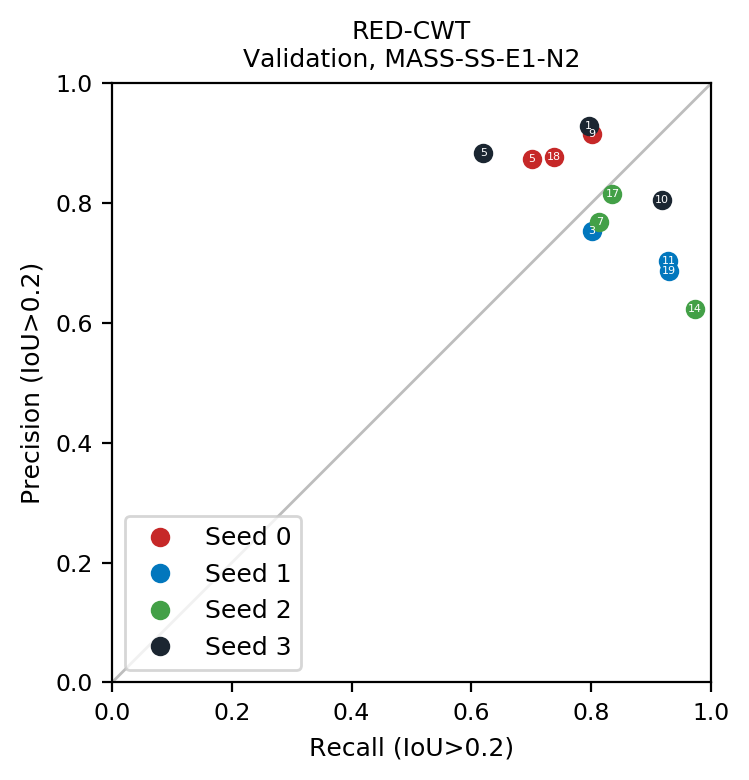

Processing val
Done
Processing val
Done
Processing val
Done
Processing val
Done
Noise0.05: Precision 80.6 +- 8.7 -- Recall 82.2 +- 9.1


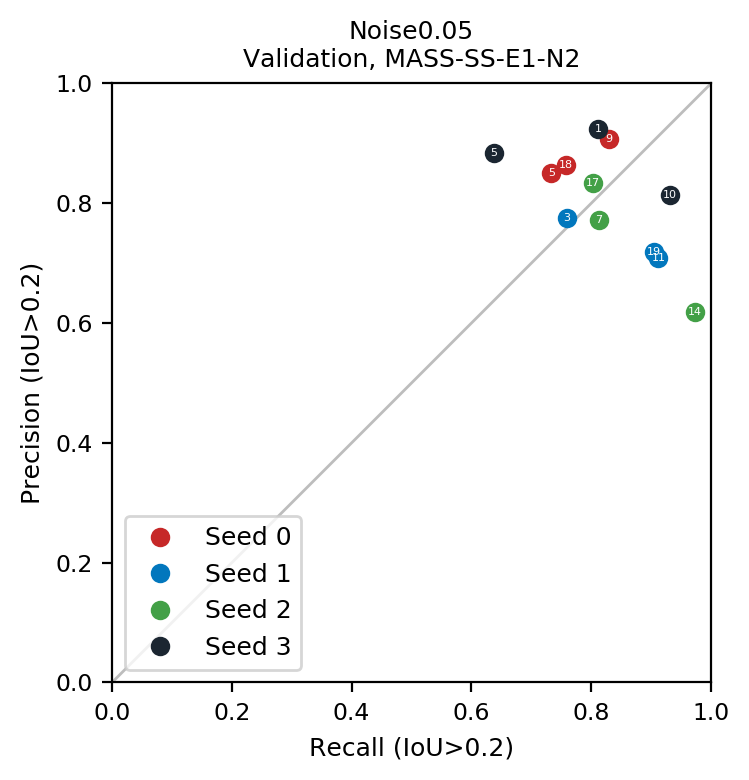

Processing val
Done
Processing val
Done
Processing val
Done
Processing val
Done
Noise0.10: Precision 80.6 +- 9.4 -- Recall 82.2 +- 9.7


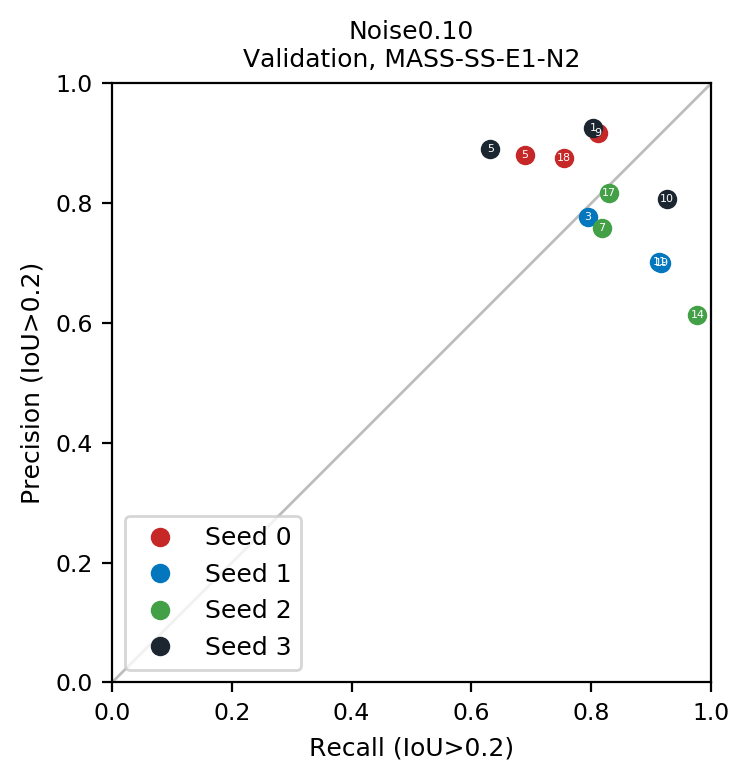

In [10]:
show_subject_id = True
seeds_to_show = [0, 1, 2, 3]
n_seeds = len(seeds_to_show)
set_list = ['val']
iou_to_show = 0.2
iou_idx = misc.closest_index(iou_to_show, iou_curve_axis) 
color_dict = {
    'train': {i: viz.GREY_COLORS[4] for i in range(4)},
    'val': {0: viz.PALETTE['red'], 1: viz.PALETTE['blue'], 2: viz.PALETTE['green'], 3: viz.PALETTE['dark']}
}
markersize_model = 6
axis_markers = [0, 0.2, 0.4, 0.6, 0.8, 1.0]

for j_m, model in enumerate(models):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=viz.DPI)
    tmp_all_recall = []
    tmp_all_precision = []
    for k_ax, seed_id_for_f1vsiou in enumerate(seeds_to_show):
        # ---------------- Compute performance
        pre_vs_iou_subject_dict = {}
        rec_vs_iou_subject_dict = {}
        for set_name in set_list:
            print('Processing %s' % set_name, flush=True)
            # Prepare expert labels
            data_inference = FeederDataset(
                dataset, ids_dict[seed_id_for_f1vsiou][set_name], task_mode, which_expert)
            this_ids = data_inference.get_ids()
            this_events_list = data_inference.get_stamps()
            # Prepare model predictions
            prediction_obj = predictions_dict[model['ckpt']][seed_id_for_f1vsiou][set_name]
            prediction_obj.set_probability_threshold(OPTIMAL_THR_FOR_CKPT_DICT[model['ckpt']][seed_id_for_f1vsiou])
            this_detections_list = prediction_obj.get_stamps()
            for i, single_id in enumerate(this_ids):
                single_events = this_events_list[i]
                single_detections = this_detections_list[i]
                this_precision = metrics.metric_vs_iou(
                    single_events, single_detections, iou_curve_axis, metric_name=constants.PRECISION)
                this_recall = metrics.metric_vs_iou(
                    single_events, single_detections, iou_curve_axis, metric_name=constants.RECALL)
                pre_vs_iou_subject_dict[single_id] = this_precision
                rec_vs_iou_subject_dict[single_id] = this_recall
        print('Done', flush=True)

        # -------------------- P L O T ----------------------    

        for set_name in set_list:
            for i, single_id in enumerate(ids_dict[seed_id_for_f1vsiou][set_name]):
                this_rec = rec_vs_iou_subject_dict[single_id][iou_idx]
                this_pre = pre_vs_iou_subject_dict[single_id][iou_idx]
                tmp_all_recall.append(this_rec)
                tmp_all_precision.append(this_pre)
                if i == 0:
                    label = 'Seed %d' % seed_id_for_f1vsiou
                else:
                    label = None
                ax.plot(
                    this_rec, this_pre, color=color_dict[set_name][seed_id_for_f1vsiou], 
                    marker='o', markersize=markersize_model, label=label, linestyle='None')
                if show_subject_id:
                    ax.annotate(
                        single_id, (this_rec, this_pre), 
                        horizontalalignment="center", verticalalignment="center", fontsize=4, color="w")
    print("%s: Precision %1.1f +- %1.1f -- Recall %1.1f +- %1.1f" % (
        model['name'], 100 * np.mean(tmp_all_precision), 100 * np.std(tmp_all_precision),
        100 * np.mean(tmp_all_recall), 100 * np.std(tmp_all_recall)
    ))
    ax.plot([0, 1], [0, 1], zorder=1, linewidth=1, color=viz.GREY_COLORS[4])
    ax.set_title('%s\nValidation, %s' % (model['name'], result_id), fontsize=9)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_yticks(axis_markers)
    ax.set_xticks(axis_markers)
    ax.tick_params(labelsize=8.5) 
    ax.set_ylabel('Precision (IoU>%1.1f)' % iou_to_show, fontsize=9)
    ax.set_xlabel('Recall (IoU>%1.1f)' % iou_to_show, fontsize=9)
    ax.set_aspect('equal')
    ax.legend(loc='lower left', fontsize=9)
    plt.tight_layout()
    if save_figs:
        plt.savefig("pr_%s_seeds.png" % model['code_name'], dpi=200, bbox_inches="tight", pad_inches=0.01)
    plt.show()

# more stuff

In [ ]:
chosen_seed = 3
set_name = 'val'

val_ids = ids_dict[chosen_seed][set_name]
subset_data = FeederDataset(dataset, val_ids, task_mode, which_expert=which_expert)
events = subset_data.get_stamps()
signals = subset_data.get_signals(normalize_clip=False)

cmp_opt_thr = []
cmp_preds = []
cmp_dets = []
cmp_probas = []
for model in models:
    t_opt_thr = OPTIMAL_THR_FOR_CKPT_DICT[model['ckpt']][chosen_seed]
    t_preds = predictions_dict[model['ckpt']][chosen_seed][set_name]
    t_preds.set_probability_threshold(t_opt_thr)
    t_dets = t_preds.get_stamps()
    t_probas = t_preds.get_probabilities()
    cmp_opt_thr.append(t_opt_thr)
    cmp_preds.append(t_preds)
    cmp_dets.append(t_dets)
    cmp_probas.append(t_probas)

matching_data_all = {}
for i, single_id in enumerate(val_ids):  
    # Matching with expert
    for j, s_dets in enumerate(cmp_dets):
        s_key = '%s_vs_exp' % models[j]['code_name']
        if i == 0:
            matching_data_all[s_key] = []
        s_iou_matching, s_idx_matching = metrics.matching(events[i], s_dets[i])
        matching_data_all[s_key].append({'iou': s_iou_matching, 'idx': s_idx_matching})
    # Matching between models
    for j_1, s_dets_1 in enumerate(cmp_dets):
        for j_2, s_dets_2 in enumerate(cmp_dets):
            if j_2<=j_1:
                continue
            s_key = '%s_vs_%s' % (models[j_2]['code_name'], models[j_1]['code_name'])
            if i == 0:
                matching_data_all[s_key] = []
            s_iou_matching, s_idx_matching = metrics.matching(s_dets_1[i], s_dets_2[i])
            matching_data_all[s_key].append({'iou': s_iou_matching, 'idx': s_idx_matching})
print("Done")

# Escalares

In [ ]:
# Desempeño por sujeto a IoU 0.2
iou_thr = 0.2
f = open('metrics_seed%d.txt' % chosen_seed, 'w')
print('Database: %s, Expert: %d' % (dataset_name, which_expert), file=f)
print('Seed %d' % chosen_seed, file=f)
for i, single_id in enumerate(val_ids):
    n_events = events[i].shape[0]
    print("", file=f)
    print('Subject %02d (%d events)' % (single_id, n_events), file=f)
    for j, model in enumerate(models):
        print("", file=f)
        print('Report for %s (IoU >= %1.1f)' % (model['name'], iou_thr), file=f)
        n_detections = cmp_dets[j][i].shape[0]
        s_key = '%s_vs_exp' % model['code_name']        
        iou_match = matching_data_all[s_key][i]['iou'][matching_data_all[s_key][i]['idx'] != -1]    
        tp = np.sum((iou_match >= iou_thr).astype(int))
        fp = n_detections - tp
        fn = n_events - tp
        precision = 100 * tp / n_detections
        recall = 100 * tp / n_events
        f1_score = 100 * 2 * tp / (n_detections + n_events)
        print('TP %03d - FP %03d - FN %03d' % (tp, fp, fn), file=f)
        print('F1 %1.1f - Precision %1.1f - Recall %1.1f' % (f1_score, precision, recall), file=f)
        mean_iou = 100 * iou_match.mean()
        low_iqr = 100 * np.percentile(iou_match, 25)
        high_iqr = 100 * np.percentile(iou_match, 75)
        print('IoU of Matchings %1.1f [%1.1f - %1.1f]' % (mean_iou, low_iqr, high_iqr), file=f)
f.close()
print("Done")

# Durations

In [ ]:
def find_durations(data_x, data_y, idx_matching):
    matched_real_idx = np.where(idx_matching > -1)[0]
    matched_det_idx = idx_matching[idx_matching > -1]
    matched_real_event = data_x[matched_real_idx]
    matched_det_event = data_y[matched_det_idx]
    matched_real_dur = matched_real_event[:, 1] - matched_real_event[:, 0]
    matched_det_dur = matched_det_event[:, 1] - matched_det_event[:, 0]
    return matched_real_dur, matched_det_dur

def linear_regression(durations_x, durations_y, min_dur, max_dur, ax):
    durations_x = durations_x.reshape(-1, 1)
    # reg = LinearRegression().fit(durations_x, durations_y)
    reg = HuberRegressor().fit(durations_x, durations_y)
    r2_score = reg.score(durations_x, durations_y)
    x_reg = np.array([min_dur, max_dur]).reshape(-1, 1)
    y_reg = reg.predict(x_reg)
    ax.plot(x_reg, y_reg, '--r', linewidth=1.1)
    delta = 0.05 * (max_dur - min_dur)
    ax.annotate(
        'R2 = %1.2f' % r2_score, 
        xy=(min_dur + delta, max_dur - delta),  
        textcoords='data',
        horizontalalignment='left', verticalalignment='top', fontsize=8)
    return ax

In [ ]:
print('Database: %s, Expert: %d' % (dataset_name, which_expert))
print('Seed %d' % chosen_seed)

dpi = 120
n_bins = 20
min_dur = 0.3
max_dur = 2.2
alpha_scatter = 0.2
ticks = [0.5, 1.0, 1.5, 2.0]
size_marker = 10

x_bins = np.linspace(min_dur, max_dur, n_bins, endpoint=True)
y_bins = np.linspace(min_dur, max_dur, n_bins, endpoint=True)
x_centers = x_bins[:-1] + x_bins[1]/2 - x_bins[0]/2
y_centers = y_bins[:-1] + y_bins[1]/2 - y_bins[0]/2
xv, yv = np.meshgrid(x_centers, y_centers)

# Models versus expert: SCATTERPLOT
n_models = len(models)
fig, ax = plt.subplots(n_models, 3, figsize=(5, 2 + 1.5*(n_models-1)), dpi=dpi)
for j, model in enumerate(models):
    ax[j, 0].set_ylabel(model['name'], fontsize=viz.FONTSIZE_GENERAL)
    for i, single_id in enumerate(val_ids):
        ax[0, i].set_title('Subject %02d' % single_id, fontsize=10)
        s_key = '%s_vs_exp' % model['code_name']
        dur_x, dur_y = find_durations(events[i], cmp_dets[j][i], matching_data_all[s_key][i]['idx'])
        dur_x, dur_y = dur_x / fs, dur_y / fs
        ax[j, i].scatter(dur_x, dur_y, alpha=alpha_scatter, color=viz.PALETTE['blue'], s=size_marker)        
        ax[j, i] = linear_regression(dur_x, dur_y, min_dur, max_dur, ax[j, i])
        if i > 0:
            ax[j, i].set_yticklabels([])
        if j == n_models-1:
            ax[j, i].set_xlabel('Expert', fontsize=viz.FONTSIZE_GENERAL)
        else:
            ax[j, i].set_xticklabels([])
for s_ax in ax.flatten():   
    s_ax.set_xlim([min_dur, max_dur])
    s_ax.set_ylim([min_dur, max_dur])
    s_ax.set_yticks(ticks)
    s_ax.set_xticks(ticks)
    s_ax.plot(
        [min_dur, max_dur], [min_dur, max_dur],
        linestyle='-', color=viz.GREY_COLORS[6], zorder=10, linewidth=1)
    s_ax.tick_params(labelsize=viz.FONTSIZE_GENERAL)
    s_ax.set_aspect('equal')
plt.tight_layout()
plt.text(
    x=0.03, y=1.0, fontsize=10, 
    s='Validation Set Seed %d (%s)' % (
        chosen_seed, result_id), 
    ha="left", transform=fig.transFigure)
if save_figs:
    plt.savefig("dur_all_vs_exp_seed%d_scat.png" % (chosen_seed), dpi=200, bbox_inches="tight", pad_inches=0.05)
plt.show()

# Models versus expert: HISTOGRAM
n_models = len(models)
fig, ax = plt.subplots(n_models, 3, figsize=(5, 2 + 1.5*(n_models-1)), dpi=dpi)
for j, model in enumerate(models):
    ax[j, 0].set_ylabel(model['name'], fontsize=viz.FONTSIZE_GENERAL)
    s_key = '%s_vs_exp' % model['code_name']
    for i, single_id in enumerate(val_ids):
        ax[0, i].set_title('Subject %02d' % single_id, fontsize=10)
        dur_x, dur_y = find_durations(events[i], cmp_dets[j][i], matching_data_all[s_key][i]['idx'])
        dur_x, dur_y = dur_x / fs, dur_y / fs
        hist, _, _ = np.histogram2d(dur_x, dur_y, bins=[x_bins, y_bins], density=True)
        hist = hist.T
        ax[j, i].hist2d(xv.flatten(), yv.flatten(), bins=[x_bins, y_bins], weights=hist.flatten(), cmap='viridis')
        if i > 0:
            ax[j, i].set_yticklabels([])
        if j == n_models-1:
            ax[j, i].set_xlabel('Expert', fontsize=viz.FONTSIZE_GENERAL)
        else:
            ax[j, i].set_xticklabels([])
for s_ax in ax.flatten():   
    s_ax.set_xlim([min_dur, max_dur])
    s_ax.set_ylim([min_dur, max_dur])
    s_ax.set_yticks(ticks)
    s_ax.set_xticks(ticks)
    s_ax.plot(
        [min_dur, max_dur], [min_dur, max_dur],
        linestyle='-', color=viz.GREY_COLORS[6], zorder=10, linewidth=1)
    s_ax.tick_params(labelsize=viz.FONTSIZE_GENERAL)
    s_ax.set_aspect('equal')
plt.tight_layout()
plt.text(
    x=0.03, y=1.0, fontsize=10, 
    s='Validation Set Seed %d (%s)' % (
        chosen_seed, result_id), 
    ha="left", transform=fig.transFigure)
if save_figs:
    plt.savefig("dur_all_vs_exp_seed%d_hist.png" % (chosen_seed), dpi=200, bbox_inches="tight", pad_inches=0.05)
plt.show()


# Models versus models: SCATTERPLOT
for j_1, s_dets_1 in enumerate(cmp_dets):
    for j_2, s_dets_2 in enumerate(cmp_dets):
        if j_2<=j_1:
            continue
        s_key = '%s_vs_%s' % (models[j_2]['code_name'], models[j_1]['code_name'])
        fig, ax = plt.subplots(1, 3, figsize=(5, 2), dpi=dpi)
        ax[0].set_ylabel(models[j_2]['name'], fontsize=viz.FONTSIZE_GENERAL)
        for i, single_id in enumerate(val_ids):
            ax[i].set_title('Subject %02d' % single_id, fontsize=10)
            dur_x, dur_y = find_durations(s_dets_1[i], s_dets_2[i], matching_data_all[s_key][i]['idx'])
            dur_x, dur_y = dur_x / fs, dur_y / fs
            ax[i].scatter(dur_x, dur_y, alpha=alpha_scatter, color=viz.PALETTE['blue'], s=size_marker)
            ax[i] = linear_regression(dur_x, dur_y, min_dur, max_dur, ax[i])
            if i > 0:
                ax[i].set_yticklabels([])
            ax[i].set_xlabel(models[j_1]['name'], fontsize=viz.FONTSIZE_GENERAL)
        for s_ax in ax.flatten():   
            s_ax.set_xlim([min_dur, max_dur])
            s_ax.set_ylim([min_dur, max_dur])
            s_ax.set_yticks(ticks)
            s_ax.set_xticks(ticks)
            s_ax.plot(
                [min_dur, max_dur], [min_dur, max_dur],
                linestyle='-', color=viz.GREY_COLORS[6], zorder=10, linewidth=1)
            s_ax.tick_params(labelsize=viz.FONTSIZE_GENERAL)
            s_ax.set_aspect('equal')
        plt.tight_layout()
        plt.text(
            x=0.03, y=1.0, fontsize=10, 
            s='Validation Set Seed %d (%s)' % (
                chosen_seed, result_id), 
            ha="left", transform=fig.transFigure)
        if save_figs:
            plt.savefig("dur_%s_vs_%s_seed%d_scat.png" % (
                    models[j_2]['code_name'], models[j_1]['code_name'], chosen_seed
                ), dpi=200, bbox_inches="tight", pad_inches=0.05)
        plt.show()
        
# Models versus models: HISTOGRAM
for j_1, s_dets_1 in enumerate(cmp_dets):
    for j_2, s_dets_2 in enumerate(cmp_dets):
        if j_2<=j_1:
            continue
        s_key = '%s_vs_%s' % (models[j_2]['code_name'], models[j_1]['code_name'])
        fig, ax = plt.subplots(1, 3, figsize=(5, 2), dpi=dpi)
        ax[0].set_ylabel(models[j_2]['name'], fontsize=viz.FONTSIZE_GENERAL)
        for i, single_id in enumerate(val_ids):
            ax[i].set_title('Subject %02d' % single_id, fontsize=10)
            dur_x, dur_y = find_durations(s_dets_1[i], s_dets_2[i], matching_data_all[s_key][i]['idx'])
            dur_x, dur_y = dur_x / fs, dur_y / fs
            hist, _, _ = np.histogram2d(dur_x, dur_y, bins=[x_bins, y_bins], density=True)
            hist = hist.T
            ax[i].hist2d(xv.flatten(), yv.flatten(), bins=[x_bins, y_bins], weights=hist.flatten(), cmap='viridis')
            if i > 0:
                ax[i].set_yticklabels([])
            ax[i].set_xlabel(models[j_1]['name'], fontsize=viz.FONTSIZE_GENERAL)
        for s_ax in ax.flatten():   
            s_ax.set_xlim([min_dur, max_dur])
            s_ax.set_ylim([min_dur, max_dur])
            s_ax.set_yticks(ticks)
            s_ax.set_xticks(ticks)
            s_ax.plot(
                [min_dur, max_dur], [min_dur, max_dur],
                linestyle='-', color=viz.GREY_COLORS[6], zorder=10, linewidth=1)
            s_ax.tick_params(labelsize=viz.FONTSIZE_GENERAL)
            s_ax.set_aspect('equal')
        plt.tight_layout()
        plt.text(
            x=0.03, y=1.0, fontsize=10, 
            s='Validation Set Seed %d (%s)' % (
                chosen_seed, result_id), 
            ha="left", transform=fig.transFigure)
        if save_figs:
            plt.savefig("dur_%s_vs_%s_seed%d_hist.png" % (
                    models[j_2]['code_name'], models[j_1]['code_name'], chosen_seed
                ), dpi=200, bbox_inches="tight", pad_inches=0.05)
        plt.show()

# Performance as a function of threshold

In [ ]:
color_list = [viz.PALETTE['red'], viz.PALETTE['blue'], viz.PALETTE['green'], viz.PALETTE['dark']]
iou_to_show = 0.2
n_points = 30
min_proba_factor = 0.1
max_proba_factor = 0.9

# Plot f1 vs iou specs
smaller_plot = False
external_legend = True
show_iou_iqr = True
figsize = (4, 4)

for j_m, model in enumerate(models):

    title = '%s\n(%s)-%s-Seed%d' % (model['name'], result_id, set_name.upper(), chosen_seed)

    # -------------------- P L O T ----------------------  
    print('Database: %s, Expert: %d' % (dataset_name, which_expert))
    print(title)
    this_dpi = 100 if smaller_plot else viz.DPI
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=this_dpi)
    probas = cmp_preds[j_m].get_probabilities()
    max_valid = np.min([s_p.max() for s_p in probas])
    min_valid = np.max([s_p[s_p>0].min() for s_p in probas])
    min_proba = min_valid + min_proba_factor * (max_valid - min_valid)
    max_proba = min_valid + max_proba_factor * (max_valid - min_valid)
    dense_thr = np.linspace(max([min_proba, 0.01]), min([max_proba, 0.99]), n_points)
    f1_evol = np.zeros((len(dense_thr), len(val_ids)))
    prec_evol = np.zeros((len(dense_thr), len(val_ids)))
    rec_evol = np.zeros((len(dense_thr), len(val_ids)))
    iou_evol = np.zeros((len(dense_thr), len(val_ids)))
    iou_evol_low_iqr = np.zeros((len(dense_thr), len(val_ids)))
    iou_evol_high_iqr = np.zeros((len(dense_thr), len(val_ids)))
    for j, s_thr in enumerate(dense_thr):
        cmp_preds[j_m].set_probability_threshold(s_thr)
        dets = cmp_preds[j_m].get_stamps()
        for i, single_id in enumerate(val_ids):
            s_events = events[i]
            s_dets = dets[i]
            s_iou_matching, s_idx_matching = metrics.matching(s_events, s_dets)
            iou_matching = s_iou_matching[s_idx_matching != -1]
            n_detections = s_dets.shape[0]
            n_events = s_events.shape[0]
            # Now, give credit only for iou >= iou_thr
            tp = np.sum((iou_matching >= iou_to_show).astype(int))
            fp = n_detections - tp
            fn = n_events - tp
            prec_evol[j, i] = tp / n_detections
            rec_evol[j, i] = tp / n_events
            f1_evol[j, i] = 2 * tp / (n_detections + n_events)
            iou_evol[j, i] = np.mean(iou_matching)
            iou_evol_low_iqr[j, i] = np.percentile(iou_matching, 25)
            iou_evol_high_iqr[j, i] = np.percentile(iou_matching, 75)
    # Mean set
    f1_evol = f1_evol.mean(axis=1)
    prec_evol = prec_evol.mean(axis=1)
    rec_evol = rec_evol.mean(axis=1)
    iou_evol = iou_evol.mean(axis=1)
    iou_evol_low_iqr = iou_evol_low_iqr.mean(axis=1)
    iou_evol_high_iqr = iou_evol_high_iqr.mean(axis=1)

    # Plots
    linewidth = 1.5
    ax.plot(dense_thr, f1_evol, label='F1-score', linewidth=linewidth, color=color_list[0], zorder=20)
    ax.plot(dense_thr, prec_evol, label='Precision', linewidth=linewidth, color=color_list[1], zorder=20)
    ax.plot(dense_thr, rec_evol, label='Recall', linewidth=linewidth, color=color_list[2], zorder=20)
    ax.plot(dense_thr, iou_evol, label='Mean IoU', linewidth=linewidth, color=color_list[3], zorder=20)
    if show_iou_iqr:
        ax.fill_between(
            dense_thr,
            iou_evol_low_iqr,
            iou_evol_high_iqr,
            facecolor=color_list[3], alpha=0.2
        )

    ax.set_title(title, fontsize=9, loc='center')

    ax.axvline(
        cmp_opt_thr[j_m],
        linestyle='-',
        color=viz.GREY_COLORS[4],
        zorder=1,
        linewidth=1)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xticks(np.linspace(0, 1, 6))
    ax.set_xticks(np.linspace(0, 1, 11), minor=True)
    ax.set_yticks(np.linspace(0.2, 1, 5))
    ax.set_yticks(np.linspace(0, 1, 11), minor=True)
    ax.tick_params(labelsize=viz.FONTSIZE_GENERAL)
    ax.set_xlabel('Output Threshold', fontsize=viz.FONTSIZE_GENERAL)
    ax.yaxis.grid(which='both')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='y', which='both', length=0)
    lg = plotter.format_legend(ax, external_legend)
    lg.set_title("IoU > %1.2f" % iou_to_show)
    lg.get_title().set_fontsize('8')
    if save_figs:
        plt.savefig(
            "thr_effect_%s_seed%d.png" % (model['code_name'], chosen_seed), 
            dpi=200, bbox_extra_artists=(lg,), bbox_inches="tight", pad_inches=0.01)
    plt.show()
    cmp_preds[j_m].set_probability_threshold(cmp_opt_thr[j_m])

# F1 vs IoU between models (agreement)

In [ ]:
f = open('agreement_seed%d.txt' % chosen_seed, 'w')
color_list = [viz.PALETTE['red'], viz.PALETTE['blue'], viz.PALETTE['green']]

# Plot f1 vs iou specs
smaller_plot = False
external_legend = True
iou_thr_to_show = 0.2
figsize = (4, 4)
# -------------------- P L O T ----------------------  
print('Database: %s, Expert: %d' % (dataset_name, which_expert), file=f)
print('IoU to show: %1.1f' % iou_thr_to_show, file=f)
this_dpi = 100 if smaller_plot else viz.DPI
dense_iou = misc.custom_linspace(0.01, 0.99, 0.01)

for j_1, s_dets_1 in enumerate(cmp_dets):
    for j_2, s_dets_2 in enumerate(cmp_dets):
        if j_2<=j_1:
            continue
        print("", file=f)
        title = '%s wrt %s (%s)' % (models[j_2]['name'], models[j_1]['name'], result_id)
        print(title, file=f)
        fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=this_dpi)
        s_key = '%s_vs_%s' % (models[j_2]['code_name'], models[j_1]['code_name'])
        for i, single_id in enumerate(val_ids):
            s_f1_curve = []
            iou_matching = matching_data_all[s_key][i]['iou'][matching_data_all[s_key][i]['idx'] != -1]
            n_detections = cmp_dets[j_2][i].shape[0]
            n_events = cmp_dets[j_1][i].shape[0]
            for single_iou in dense_iou:
                # Now, give credit only for iou >= iou_thr
                tp = np.sum((iou_matching >= single_iou).astype(int))
                fp = n_detections - tp
                fn = n_events - tp
                precision = tp / n_detections
                recall = tp / n_events
                f1_score = 2 * tp / (n_detections + n_events)
                s_f1_curve.append(f1_score)
                if np.abs(single_iou - 0.2) <= 1e-4:
                    print("", file=f)
                    print('Subject %02d at IoU >= 0.2' % single_id, file=f)
                    print('F1 %1.1f - Precision %1.1f - Recall %1.1f' % (
                        f1_score * 100, precision * 100, recall * 100
                    ), file=f)
                    mean_iou = 100 * iou_matching.mean()
                    low_iqr = 100 * np.percentile(iou_matching, 25)
                    high_iqr = 100 * np.percentile(iou_matching, 75)
                    print('IoU of Matchings %1.1f [%1.1f - %1.1f]' % (mean_iou, low_iqr, high_iqr), file=f)
                    print('Min IoU of matching: %1.1f' % (100 * np.min(iou_matching)), file=f)
            this_color = color_list[i]
            ax.plot(
                dense_iou, s_f1_curve, linewidth=viz.LINEWIDTH, zorder=10, 
                label='Subject %02d' % single_id, color=this_color
            )

        ax.set_title(title, fontsize=viz.FONTSIZE_TITLE, loc='center')
        ax = plotter.format_metric_vs_iou_plot(ax, 'F1-score', iou_thr_to_show)
        lg = plotter.format_legend(ax, external_legend)
        lg.set_title("Val Set\nSeed %d" % chosen_seed)
        lg.get_title().set_fontsize('8')
        if save_figs:
            plt.savefig(
                "f1_agree_%s_vs_%s_seed%d.png" % (models[j_2]['code_name'], models[j_1]['code_name'], chosen_seed), 
                dpi=200, bbox_extra_artists=(lg,), bbox_inches="tight", pad_inches=0.01)
        plt.show()
f.close()